# Интернет-магазин "Стримчик"

**Цель исследования**

Необходимо выявить закономерности определяющие успешность игры, для планирования рекламных компаний. Определим актуальный период на основе которого будем делать прогноз на 2017 год.

**Ход исследования**

Предоставлены исторические данные о продажах игр, оценки пользователей и экспертов, жанры и платформы до 2016 года.

Изучим и подготовим данные.

Проведем исследовательский анализ данных и составим портрет пользователя.

Проверим гипотезы.


**Описание данных**

+ Name — название игры
+ Platform — платформа
+ Year_of_Release — год выпуска
+ Genre — жанр игры
+ NA_sales — продажи в Северной Америке (миллионы проданных копий)
+ EU_sales — продажи в Европе (миллионы проданных копий)
+ JP_sales — продажи в Японии (миллионы проданных копий)
+ Other_sales — продажи в других странах (миллионы проданных копий)
+ Critic_Score — оценка критиков (максимум 100)
+ User_Score — оценка пользователей (максимум 10)
+ Rating — рейтинг от организации ESRB (англ. Entertainment Software Rating Board). Эта ассоциация определяет рейтинг компьютерных игр и присваивает им подходящую возрастную категорию.

## Откроем файл с данными и изучим общую информацию ##

In [1]:
# импортируем библиотеки
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import binom, poisson, norm
from scipy import stats as st


In [2]:
# прочтем файл и создадим датафрейм
df_game = pd.read_csv('/datasets/games.csv')

In [3]:
# посмотрим первые 10 строк
df_game.head(10)

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN
5,Tetris,GB,1989.0,Puzzle,23.20,2.26,4.22,0.58,NaN,NaN,NaN
6,New Super Mario Bros.,DS,2006.0,Platform,11.28,9.14,6.50,2.88,89.0,8.5,E
7,Wii Play,Wii,2006.0,Misc,13.96,9.18,2.93,2.84,58.0,6.6,E
8,New Super Mario Bros. Wii,Wii,2009.0,Platform,14.44,6.94,4.70,2.24,87.0,8.4,E
9,Duck Hunt,NES,1984.0,Shooter,26.93,0.63,0.28,0.47,NaN,NaN,NaN


In [4]:
# посмотрим информацию о датафрейме
df_game.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


**Вывод** Посмотрели датафрейм, в нем содержится информация: название игры; платфорама; год выпуска; жанр; продажи в Саверной Америке, Европе, Японии и других странах; оценки критиков и пользователей; рейтинг. 

Получив первичную информацию, можем выделить: 
- столбцы "Name", "Year_of_Release", "Genre", "Critic_Score", "User_Score", "Rating" имеют пропуски
- необходимо привести столбцы к нижнему регистру
- тип float64 и object для некоторых столбцов не корректны. 

## Подготовка данных ##

### Приведём названия столбцов к нижнему регистру

In [5]:
# приведем столбцы к нижнему регистру
df_game.columns = df_game.columns.str.lower()

### Обработаем пропуски и заменим типы столбцов

In [6]:
# проверим наличие пропусков
df_game.isna().sum()

name                  2
platform              0
year_of_release     269
genre                 2
na_sales              0
eu_sales              0
jp_sales              0
other_sales           0
critic_score       8578
user_score         6701
rating             6766
dtype: int64

In [7]:
# посмотрим на пропущеные значения
df_game[df_game['name'].isna()]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
659,NaN,GEN,1993.0,NaN,1.78,0.53,0.00,0.08,NaN,NaN,NaN
14244,NaN,GEN,1993.0,NaN,0.00,0.00,0.03,0.00,NaN,NaN,NaN


In [8]:
# удалим пропуски
df_game = df_game.dropna(subset=['name'])

*Комментарий*
Пропуски в столбце genre соответствуют пропускам столбца name. Мы не можем заменить название игры на что-то, так как не понятно о какой игре идет речь, и так же не можем узнать жанр. Удалили пропуски.

In [9]:
# посмотрим на уникальные значения в столбце
df_game['year_of_release'].unique()

array([2006., 1985., 2008., 2009., 1996., 1989., 1984., 2005., 1999.,
       2007., 2010., 2013., 2004., 1990., 1988., 2002., 2001., 2011.,
       1998., 2015., 2012., 2014., 1992., 1997., 1993., 1994., 1982.,
       2016., 2003., 1986., 2000.,   nan, 1995., 1991., 1981., 1987.,
       1980., 1983.])

In [10]:
# удалим пропуски
df_game = df_game.dropna(subset=['year_of_release'])

*Комментарий* 
В столбце year_of_release 269 пропусков. Пропуски могли появится по причине некорректного заполнении данных об игре, либо на момент запуска не знали точной даты. Мы видим в названиях некоторых игр указан год, но для каждой игры проблематично в ручную указывать год, поэтому удалим пропуски и поменяем тип данны на int. 269 пропусков в столбце year_of_release, при удалении получиться 1,6% от общего объема. Это не критично, мы в дальнейшем будем сокращать датасет, фильтруя по году релиза. 

In [11]:
# поменяем тип данных 
df_game['year_of_release'] = df_game['year_of_release'].astype('int64')


In [12]:
# посмотрим на уникальные значения
df_game['critic_score'].unique()

array([76., nan, 82., 80., 89., 58., 87., 91., 61., 97., 95., 77., 88.,
       83., 94., 93., 85., 86., 98., 96., 90., 84., 73., 74., 78., 92.,
       71., 72., 68., 62., 49., 67., 81., 66., 56., 79., 70., 59., 64.,
       75., 60., 63., 69., 50., 25., 42., 44., 55., 48., 57., 29., 47.,
       65., 54., 20., 53., 37., 38., 33., 52., 30., 32., 43., 45., 51.,
       40., 46., 39., 34., 41., 36., 31., 27., 35., 26., 19., 28., 23.,
       24., 21., 17., 13.])

In [13]:
# посмотрим на пропущенные значения
df_game[df_game['critic_score'].isna()]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
1,Super Mario Bros.,NES,1985,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN
5,Tetris,GB,1989,Puzzle,23.20,2.26,4.22,0.58,NaN,NaN,NaN
9,Duck Hunt,NES,1984,Shooter,26.93,0.63,0.28,0.47,NaN,NaN,NaN
10,Nintendogs,DS,2005,Simulation,9.05,10.95,1.93,2.74,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
16710,Samurai Warriors: Sanada Maru,PS3,2016,Action,0.00,0.00,0.01,0.00,NaN,NaN,NaN
16711,LMA Manager 2007,X360,2006,Sports,0.00,0.01,0.00,0.00,NaN,NaN,NaN
16712,Haitaka no Psychedelica,PSV,2016,Adventure,0.00,0.00,0.01,0.00,NaN,NaN,NaN
16713,Spirits & Spells,GBA,2003,Platform,0.01,0.00,0.00,0.00,NaN,NaN,NaN


In [14]:
df_game['critic_score'].describe()

count    7983.000000
mean       68.994363
std        13.920060
min        13.000000
25%        60.000000
50%        71.000000
75%        79.000000
max        98.000000
Name: critic_score, dtype: float64

In [15]:
# заменим nan на условное число 101
df_game['critic_score'] = df_game['critic_score'].fillna(101)

*Комментарий* Не ясно на сколько корректно будет менять "оценку критиков" на медиану, она очень субьективна и может зависить от того на какой платформе вышла игра. Мы можем заполнить пропуски "заглушкой", условным числом 101, так как 98 максимальное значение оценки критиков из 100 бальной системы. Пропуски могли быть вызваны некорректным заполнением, или игры просто не были оценены, или они могли быть недавно вышедшими, и их не успели оценить. 

In [16]:
# посмотрим на уникальные значения
df_game['user_score'].unique()

array(['8', nan, '8.3', '8.5', '6.6', '8.4', '8.6', '7.7', '6.3', '7.4',
       '8.2', '9', '7.9', '8.1', '8.7', '7.1', '3.4', '5.3', '4.8', '3.2',
       '8.9', '6.4', '7.8', '7.5', '2.6', '7.2', '9.2', '7', '7.3', '4.3',
       '7.6', '5.7', '5', '9.1', '6.5', 'tbd', '8.8', '6.9', '9.4', '6.8',
       '6.1', '6.7', '5.4', '4', '4.9', '4.5', '9.3', '6.2', '4.2', '6',
       '3.7', '4.1', '5.8', '5.6', '5.5', '4.4', '4.6', '5.9', '3.9',
       '3.1', '2.9', '5.2', '3.3', '4.7', '5.1', '3.5', '2.5', '1.9', '3',
       '2.7', '2.2', '2', '9.5', '2.1', '3.6', '2.8', '1.8', '3.8', '0',
       '1.6', '9.6', '2.4', '1.7', '1.1', '0.3', '1.5', '0.7', '1.2',
       '2.3', '0.5', '1.3', '0.2', '0.6', '1.4', '0.9', '1', '9.7'],
      dtype=object)

In [17]:
# заменим nan на условное число 11
df_game['user_score'] = df_game['user_score'].fillna(11)

In [18]:
# заменим tbd на условное число 12
df_game.loc[df_game['user_score'] == 'tbd', 'user_score'] = 12

In [19]:
# поменяем тип
df_game['user_score'] = df_game['user_score'].astype('float')

*Комментарий* В столбце user_score нашли пропуски nan и значение 'tbd'. Согласно статье на wildwolfs.ru термин TBD означает To Be Determined, то есть "Будет определено". 

> Очень часто подобное сокращение можно встретить в анонсах компьютерных игр в графе "Дата выхода". Когда разработчик той или иной игры уже сообщил о том, что она готовится к выходу, но пока еще не может назвать точную дату, именно это сокращение и используется. Естественно, оно может применяться и в других случаях, но данный вариант является самым распространенным. Стоит отметить также, что у этой аббревиатуры могут быть и иные значения, например To Be Done - должно быть сделано, или To Be Discussed - подлежит обсуждению.

В нашем случае, значение может быть интерпритированно как To Be Discussed - подлежит обсуждению. Вероятно появление этого значения в наших данных связано с затруднением оценки, либо их было не достаточно для определения. 

В этом столбце 10 бальная система оценки, как и в предыдущем столбце, заменим nan на условное число 11. И значение 'tbd' заменим на 12. И поменяем тип данных на float.

In [20]:
# посмотрим на уникальные значения
df_game['rating'].unique()

array(['E', nan, 'M', 'T', 'E10+', 'K-A', 'AO', 'EC', 'RP'], dtype=object)

In [21]:
# заменим nan на undefined
df_game['rating'] = df_game['rating'].fillna('undefined')

*Комментарий* В столбце "рейтинг" мы видим nan, заменим его на undefined, так как мы не знаем какое нужно ставить возрастное ограничение для этих игр. Пропуски могут быть не связанны с ошибкой, игры могут выпускаться не только для Северной Америки и рейтинг ESRB может там не использоваться. Согласно статье на dic.academic.ru все остальные значения в столбце корректны. 

In [22]:
# проверим наличие полных дубликатов
df_game.duplicated().sum()

0

In [23]:
# проверим наличие неявных дубликатов
df_game[df_game[['name', 'platform','year_of_release']].duplicated(keep=False)]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
604,Madden NFL 13,PS3,2012,Sports,2.11,0.22,0.0,0.23,83.0,5.5,E
16230,Madden NFL 13,PS3,2012,Sports,0.00,0.01,0.0,0.00,83.0,5.5,E


In [24]:
# удалим неявные дубликаты
df_game = df_game.drop_duplicates(subset=["name", "platform", "year_of_release"])

*Комментарий*
Полных дубликатов не нашла. Проверила наличие неявных дубликатов и удалила.

### Посчитаем суммарные продажи во всех регионах и запишем их в отдельный столбец

In [25]:
# посчитаем суммарные продажи во всех регионах и запишем в отдельный столбец
df_game['total_sales'] = df_game['na_sales'] + df_game['eu_sales'] + df_game['jp_sales'] + df_game['other_sales'] 

In [26]:
df_game.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
0,Wii Sports,Wii,2006,Sports,41.36,28.96,3.77,8.45,76.0,8.0,E,82.54
1,Super Mario Bros.,NES,1985,Platform,29.08,3.58,6.81,0.77,101.0,11.0,undefined,40.24
2,Mario Kart Wii,Wii,2008,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E,35.52
3,Wii Sports Resort,Wii,2009,Sports,15.61,10.93,3.28,2.95,80.0,8.0,E,32.77
4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,11.27,8.89,10.22,1.00,101.0,11.0,undefined,31.38


**Вывод**

На стадии подготовки привела столбцы к единому регистру. В столбце name  и genre пропущенные значения изменила на unknown. Не могу сказать, как в дальнейшем эти данные повлияют на анализ, но не стала их удалять. В столбцах year_of_release, critic_score, user_score, rating так же были замечены пропуски и значение tbd. Для столбцов вместо nan были произведены замены на условные числа, превышающие на 1 системы оценок (соответственно 101 и 11). Значение tbd заменила на 12, так как посчитала, что в наших данных оно имеет значение "подлежит обсуждению", и оценка не была выставлена из-за малого количества собранных данных. В столбце year_of_release удалила строки с пропусками. Для столбца rating пропущеные значения были заменены на undefined. Посчитала не верным удалять эти строки, так как лишимся большого количества данных. Вывела отдельный столбец с суммарными продажами.

## Проведём исследовательский анализ данных ##

### Посмотрим, сколько игр выпускалось в разные годы

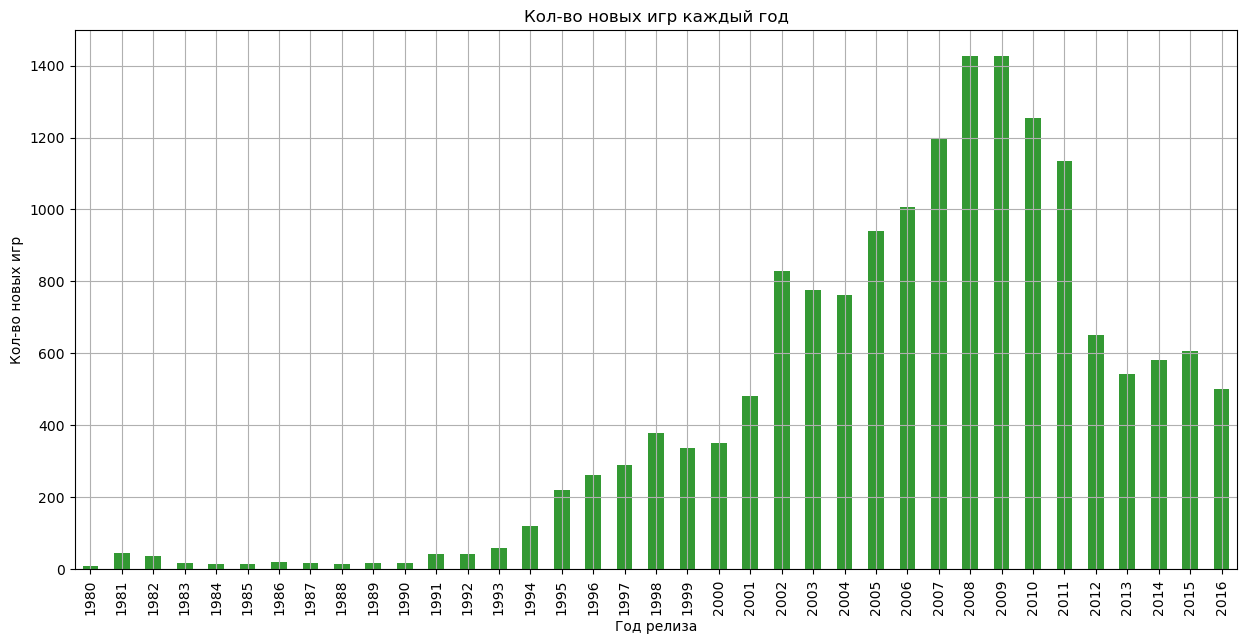

In [27]:
# посмотрим, сколько игр выпускалось в разные годы
# построим граффик
(
    df_game.pivot_table(index = 'year_of_release', values = 'name', aggfunc = 'count')\
    .plot(y='name', kind='bar', figsize=(15, 7), title='Кол-во новых игр каждый год', grid=True, color='g', alpha=0.8, legend=False)\
    .set(xlabel='Год релиза', ylabel='Кол-во новых игр')
)
plt.show()

*Комментарий* На гистограмме видим, что в 2001 начался рост игр, пик приходится на 2008 и 2009 годы, далее с 2012 снижение почти вдвое. Наиболее интересная для нас выборка приходится на диапазон с 1994 по 2016 годы, но можно сказать, что болле актуально рассматривать данные с 2002 по 2016, потому что более старые игры могли морально устареть, либо их могли перевыпустить обновленными.

### Посмотрим, как менялись продажи по платформам. Выберем платформы с наибольшими суммарными продажами и построим распределение по годам.

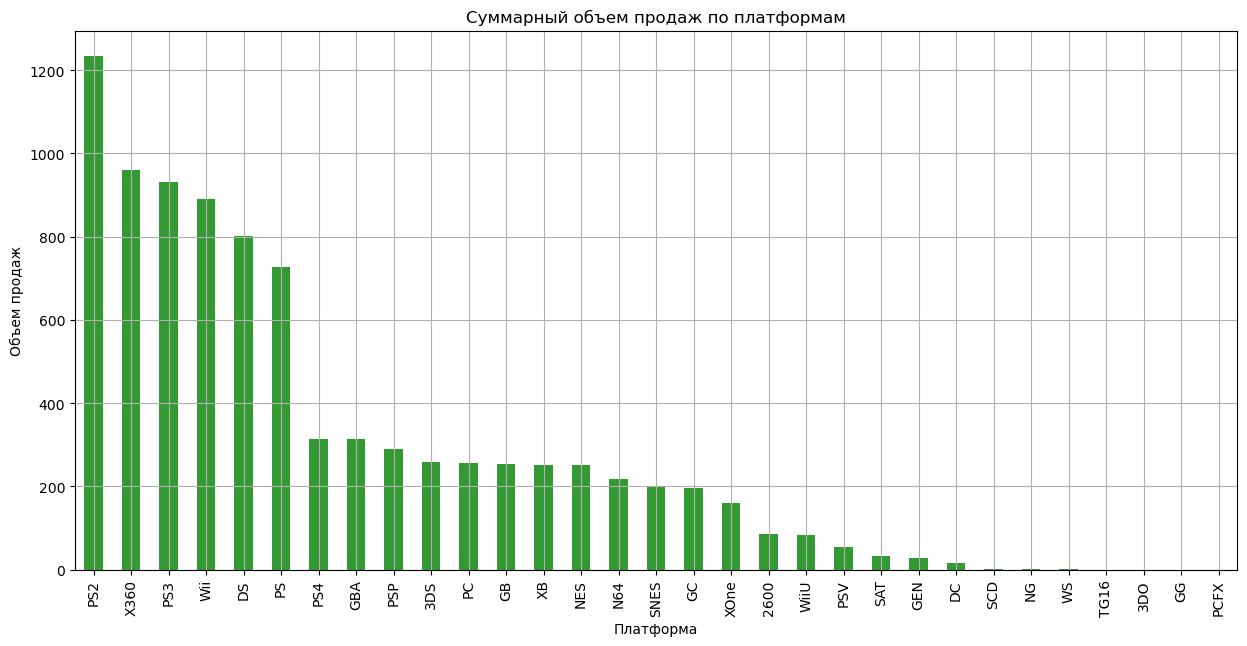

In [28]:
# создадим сводную таблицу продаж по платформам
(
    df_game.pivot_table(index = 'platform', values = 'total_sales', aggfunc = 'sum')\
    .sort_values('total_sales', ascending = False)\
    .plot(y='total_sales', kind='bar', figsize=(15, 7), title='Суммарный объем продаж по платформам', grid=True, color='g', alpha=0.8, legend=False)\
    .set(xlabel='Платформа', ylabel='Объем продаж')
)
plt.show()         

*Комментарий* По граффику видим, что платформы: PS2, X360, PS3, Wii, DS, PS, значительно превосходят по продажам остальные платформы за весь период. 

In [29]:
# построим распределения по годам, выбрав 6 перечисленых выше платформ. Сделаем срезы и построим сводные таблицы
PS2 = df_game.query('platform == "PS2"').pivot_table(index = 'year_of_release', values = 'total_sales', aggfunc = 'sum')
X360 = df_game.query('platform == "X360"').pivot_table(index = 'year_of_release', values = 'total_sales', aggfunc = 'sum')
PS3 = df_game.query('platform == "PS3"').pivot_table(index = 'year_of_release', values = 'total_sales', aggfunc = 'sum')
Wii = df_game.query('platform == "Wii"').pivot_table(index = 'year_of_release', values = 'total_sales', aggfunc = 'sum')
DS = df_game.query('platform == "DS"').pivot_table(index = 'year_of_release', values = 'total_sales', aggfunc = 'sum')
PS = df_game.query('platform == "PS"').pivot_table(index = 'year_of_release', values = 'total_sales', aggfunc = 'sum')

In [30]:
# объединим данные в единую таблицу top
top = (
    PS2.merge(X360, how = 'outer', on = 'year_of_release')
    .merge(PS3, how = 'outer', on = 'year_of_release')
    .merge(Wii, how = 'outer', on = 'year_of_release')
    .merge(DS, how = 'outer', on = 'year_of_release')
    .merge(PS, how = 'outer', on = 'year_of_release')
)
top.columns = ['PS2', 'X360', 'PS3', 'Wii', 'DS', 'PS']

C:\Users\Regina\AppData\Local\Temp\ipykernel_2428\631711761.py:5: FutureWarning: Passing 'suffixes' which cause duplicate columns {'total_sales_x'} in the result is deprecated and will raise a MergeError in a future version.
  .merge(Wii, how = 'outer', on = 'year_of_release')
C:\Users\Regina\AppData\Local\Temp\ipykernel_2428\631711761.py:7: FutureWarning: Passing 'suffixes' which cause duplicate columns {'total_sales_x'} in the result is deprecated and will raise a MergeError in a future version.
  .merge(PS, how = 'outer', on = 'year_of_release')


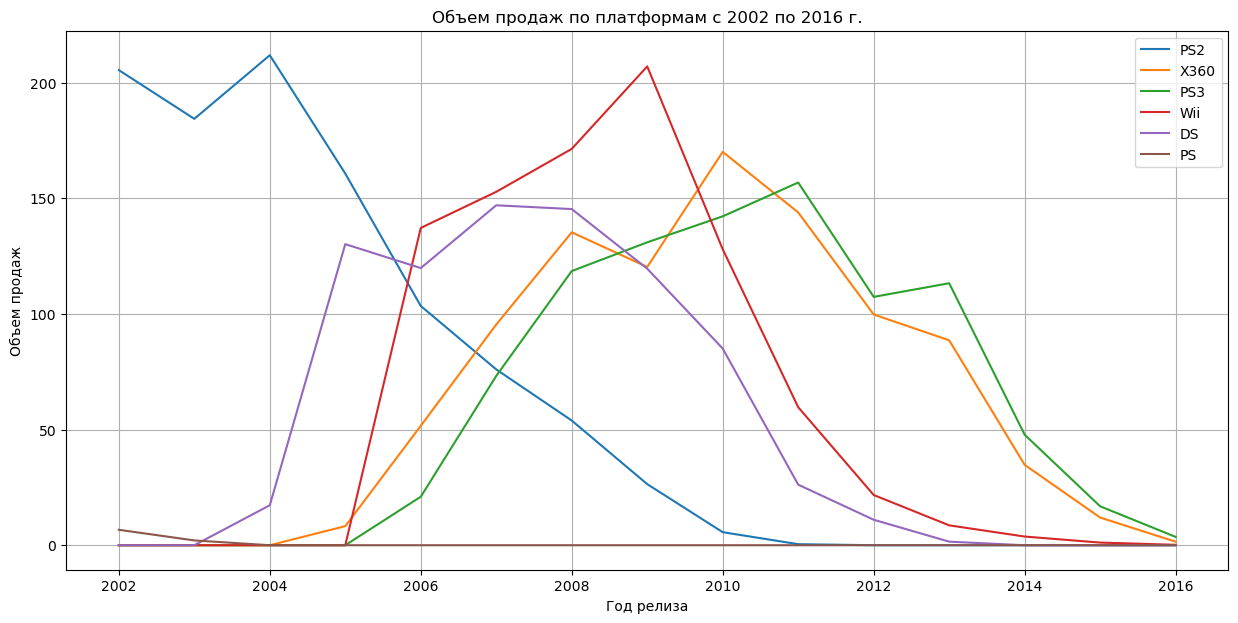

In [31]:
# построим граффик со срезом по годам от 2002 по 2016
top = (
    top.query('year_of_release >= 2002').fillna(0)
    .plot(figsize=(15, 7), title = 'Объем продаж по платформам с 2002 по 2016 г.', grid=True)
    .set(xlabel='Год релиза', ylabel='Объем продаж')
)
plt.legend()
plt.show()  

*Комментарий* По построенному граффику видим,что платформа PS не смотря на предыдущий граффик с объемом продаж, не попадает в выбраный антульный период. 

In [32]:
# определим срок жизни платформы
df = df_game[df_game['year_of_release'] != 0].copy()
life = df.pivot_table(index='platform', values='year_of_release', aggfunc=['min', 'max']).reset_index()
life['year'] = life['max'] - life['min'] + 1
life['year'].median()

7.0

**Вывод**
Мы видим, что в среднем платформы живут около 7 лет. Первый период -  около 3,5 - 4 лет, платформы набирают популярность, вероятно выходит много игр. Второй период - последующие 3,5 - 4 года популярность снижается. Может создается меньше игр для старых платформ, для того что бы запустить новые версии платформ, это можем отследить по PS2 и PS3.

"Актуальный период" для построения прогноза на 2017 год, возьмем второй период жизни платформ из нашего граффика - с 2012 по 2016 г.

###  Возьмём данные за соответствующий актуальный период

In [33]:
# сделаю срез данных за этот период и сохраню в новой таблице
period = df_game.query('year_of_release >= 2012')

In [34]:
period.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
16,Grand Theft Auto V,PS3,2013,Action,7.02,9.09,0.98,3.96,97.0,8.2,M,21.05
23,Grand Theft Auto V,X360,2013,Action,9.66,5.14,0.06,1.41,97.0,8.1,M,16.27
31,Call of Duty: Black Ops 3,PS4,2015,Shooter,6.03,5.86,0.36,2.38,101.0,11.0,undefined,14.63
33,Pokemon X/Pokemon Y,3DS,2013,Role-Playing,5.28,4.19,4.35,0.78,101.0,11.0,undefined,14.60
34,Call of Duty: Black Ops II,PS3,2012,Shooter,4.99,5.73,0.65,2.42,83.0,5.3,M,13.79


### Определим, какие платформы лидируют по продажам, растут или падают. Выберем несколько потенциально прибыльных платформ.

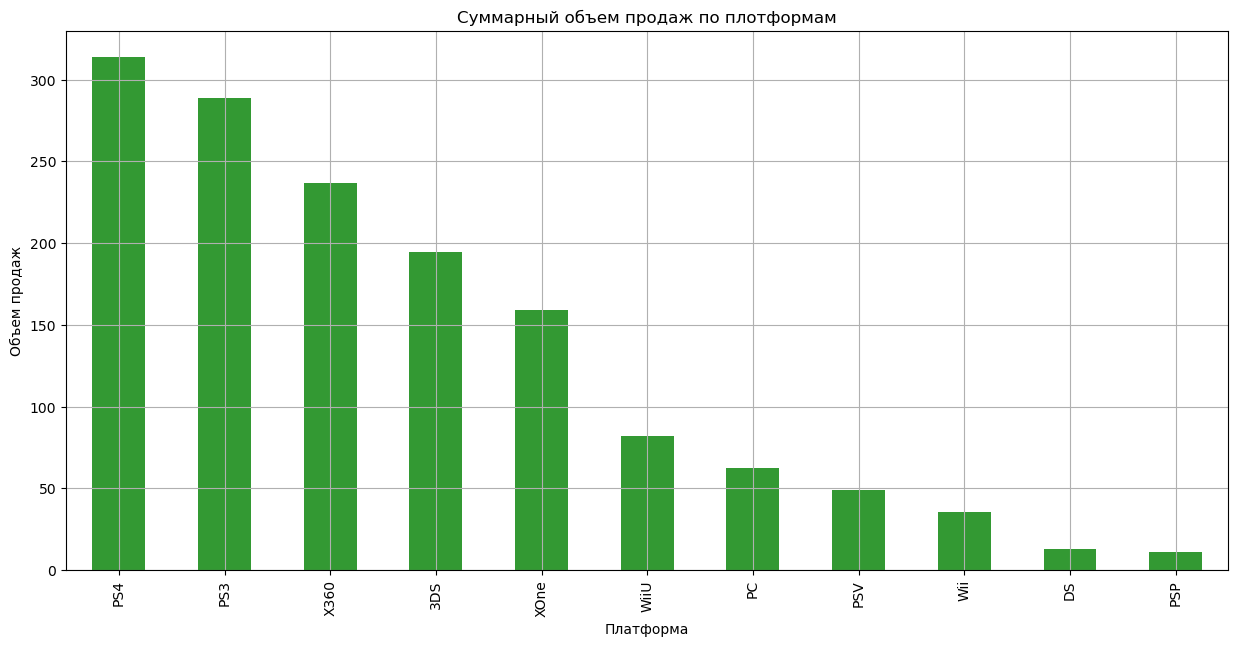

In [35]:
(
    period.pivot_table(index = 'platform', values = 'total_sales', aggfunc = sum)\
    .sort_values('total_sales', ascending = False)\
    .plot(y = 'total_sales', kind='bar', figsize=(15, 7), title='Суммарный объем продаж по плотформам', grid=True, color='g', alpha=0.8, legend=False)\
    .set(xlabel='Платформа', ylabel='Объем продаж')
)
plt.show()

*Комментарий* Лидируют по продажам: PS4, PS3, X360, 3DS, XOne. Остальные платформы продаются хуже, вероятно это устаревшие модели, либо они не пользуются популярностью в большинстве стран. 

### Построим график «ящик с усами» по глобальным продажам игр в разбивке по платформам

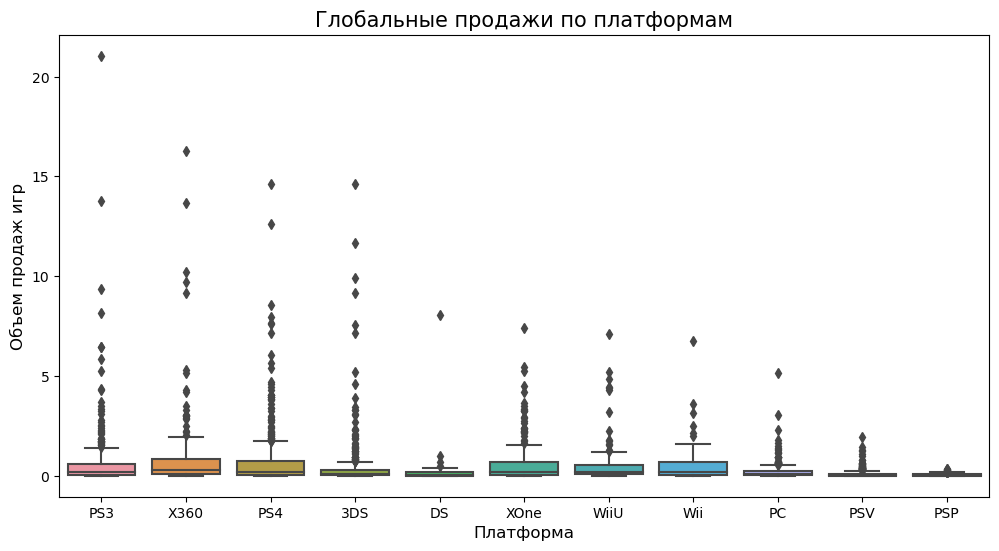

In [36]:
# график размаха со всеми выборсами
plt.figure(figsize=(12,6))
sns.boxplot(data=period, x='platform', y='total_sales')
plt.title('Глобальные продажи по платформам', fontsize=15)
plt.xlabel('Платформа', fontsize=12)
plt.ylabel('Объем продаж игр',fontsize=12);

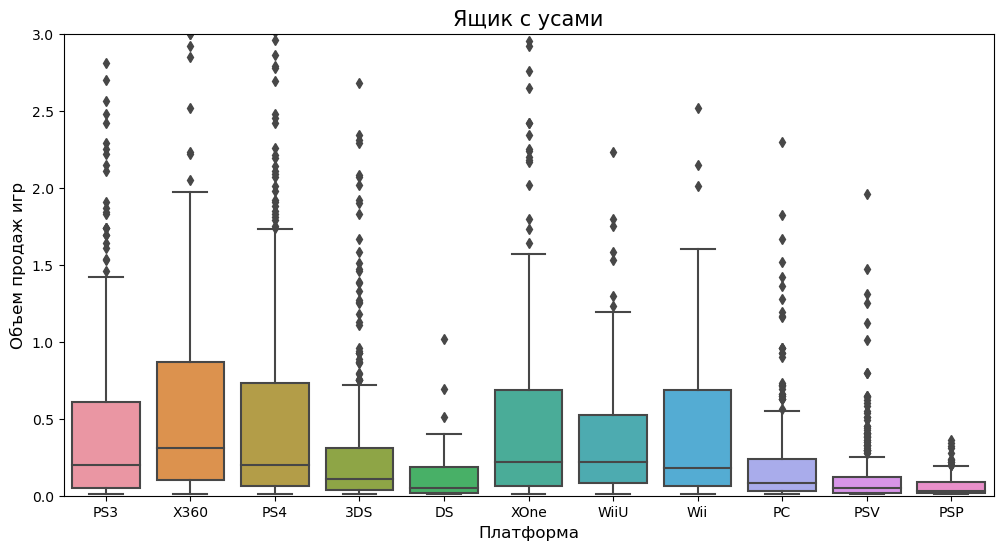

In [37]:
# график размаха масштабированный
plt.figure(figsize=(12,6))
sns.boxplot(data=period, x='platform', y='total_sales')
plt.ylim([0, 3])
plt.title('Ящик с усами', fontsize=15)
plt.xlabel('Платформа', fontsize=12)
plt.ylabel('Объем продаж игр',fontsize=12);

*Комментарий* Построила граффик с усами. Можем видеть, что медиана у многих разниться, похожие показатели у двух платформ PS3 и XOne - примерно 0,17 мил. долларов. Паказатели X360 выглядят выше, чем у других платформ: медиана на уровне 0,25 мил., третий квартиль на уровне примерно 0,54 мил. Наименьшие показатели у 3DS и много выбросов, медиана примерно 0,1 мил., третий квартиль 0,26 мил. Платформа PS4 имеет медиану 0,12 мил., третий квартиль 0,33 мил. 

Расположение боксплота и медиана показывает, что у X360, PS3, PS4 стабильно высокие продажи. Стримчик может ориентироваться на эти плотформы в 2017 году.

### Посмотрим, как влияют на продажи внутри одной популярной платформы отзывы пользователей и критиков. Построем диаграмму рассеяния и посчитаем корреляцию между отзывами и продажами.

In [38]:
# сформирую таблицу для платформы PS4 с откорректированными оценками пользователей
corr_ps4_u = period.query('platform =="PS4" and user_score < 11')

In [39]:
# корреляция между отзывами пользователей и продажами
print('Корреляция между отзывами пользователей и продажами:', \
      corr_ps4_u.query('user_score > 0')['user_score'].corr(corr_ps4_u.query('total_sales > 0')['total_sales']))

Корреляция между отзывами пользователей и продажами: -0.03195711020455644


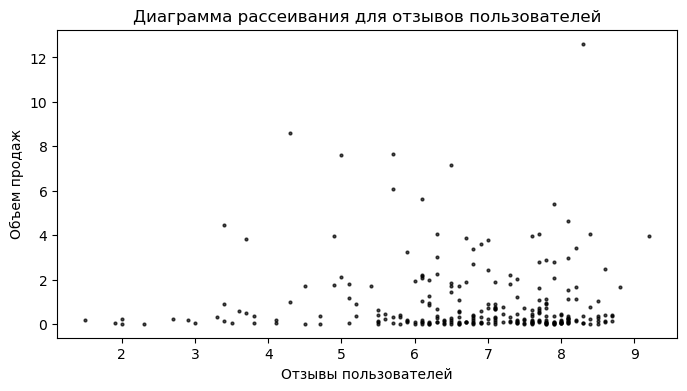

In [40]:
# построим диаграмму рассеивания для отзывов пользователей
corr_ps4_u.query('user_score > 0 and total_sales > 0')\
    .plot(kind='scatter', y='total_sales' , x='user_score', alpha=0.7, subplots=True, figsize=(8,4), c = 'black', s = 4)
plt.xlabel('Отзывы пользователей')
plt.ylabel('Объем продаж')
plt.title('Диаграмма рассеивания для отзывов пользователей');

*Комментарий* Корреляция -0.03 оценок пользователей к продажам. Взаимосвязь влияния оценок пользователей на продажи платформы PS4 отсутствует. В основном пользователи платформы выставляю оценки в диапазоне от 6 до 8,5 баллов.

In [41]:
# сформирую таблицу для платформы PS4 с откорректированными оценками критиков
corr_ps4_с = period.query('platform =="PS4" and critic_score < 101')

In [42]:
# корреляция между отзывами критиков и прожажами
print('Корреляция между отзывами критиков и прожажами:',\
      corr_ps4_с.query('critic_score > 0')['critic_score'].corr(corr_ps4_с.query('total_sales > 0')['total_sales']))

Корреляция между отзывами критиков и прожажами: 0.40656790206178123


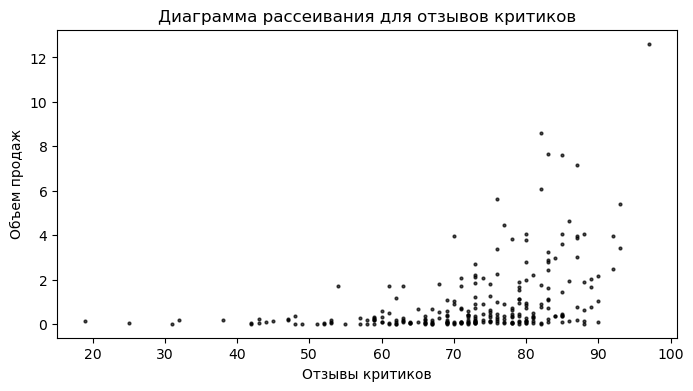

In [43]:
# построим диаграмму рассеивания для отзывов критиков
corr_ps4_с.plot(kind='scatter', y='total_sales' , x='critic_score', alpha=0.7, subplots=True, figsize=(8,4), c = 'black', s = 4)
plt.xlabel('Отзывы критиков')
plt.ylabel('Объем продаж')
plt.title('Диаграмма рассеивания для отзывов критиков');

*Комментарий* Корреляция оценки критиков к продажам слабая - 0.4. Продажи платформы PS4 слабо зависят от мнения критиков, но можем сказать, что небольшое влияние их оценки на продажи присутствует. Основные оценки критиков расположены в диапазоне от 60 до 90 баллов. 

### Соотнесём выводы с продажами игр на других платформах.

In [44]:
# рассмотрим корреляцию по оценкам пользователей всех популярных платформ
print('Корреляция оценок пользователей всех популярных платформ:',\
      period.query('user_score < 11')['user_score'].corr(period.query('user_score < 11')['total_sales']))

Корреляция оценок пользователей всех популярных платформ: 0.004194481106917198


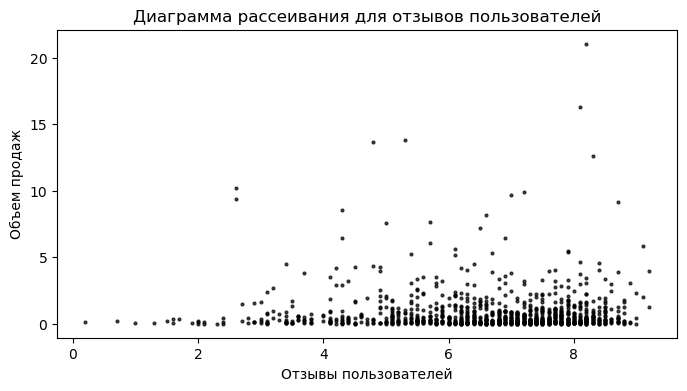

In [45]:
# построим диаграмму рассеивания для всех популярных платформ
period.query('platform == ["PS4", "PS3", "X360", "3DS", "XOne"] and user_score < 11 and user_score > 0')\
.plot(kind='scatter', y='total_sales' , x='user_score', alpha=0.7, subplots=True, figsize=(8,4), c = 'black', s = 4)
plt.xlabel('Отзывы пользователей')
plt.ylabel('Объем продаж')
plt.title('Диаграмма рассеивания для отзывов пользователей');

In [46]:
# рассмотрим корреляцию оценок критиков по всем популярным платформам
print('Корреляция оценок критиков по всем популярным платформам:', period.query('critic_score < 101')['critic_score']\
.corr(period.query('critic_score < 101')['total_sales']))

Корреляция оценок критиков по всем популярным платформам: 0.3086333612897606


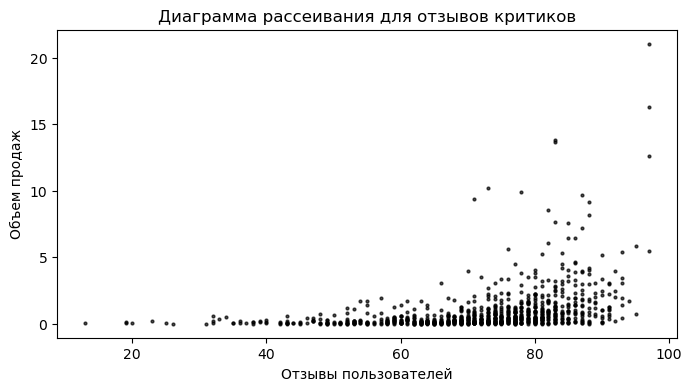

In [47]:
# построим диаграмму рассеивания для всех популярных платформ
period.query('platform == ["PS4", "PS3", "X360", "3DS", "XOne"] and critic_score < 101')\
.plot(kind='scatter', y='total_sales' , x='critic_score', alpha=0.7, subplots=True, figsize=(8,4), c = 'black', s = 4)
plt.xlabel('Отзывы пользователей')
plt.ylabel('Объем продаж')
plt.title('Диаграмма рассеивания для отзывов критиков');

In [48]:
# рассмотрим корреляцию оценок пользователей по платформе PS3
corr_ps3 = period.query('platform =="PS3" and user_score < 11')
print('Корреляция оценки пользователей и продаж для платформы PS3:', corr_ps3['user_score'].corr(corr_ps3['total_sales']))

Корреляция оценки пользователей и продаж для платформы PS3: -0.0062057676860515125


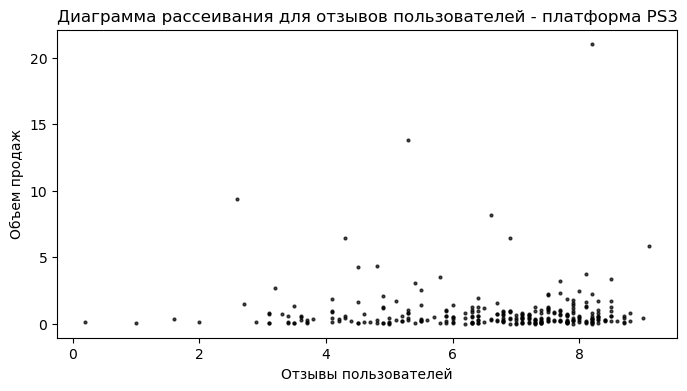

In [49]:
# построим диаграмму для платформы PS3
corr_ps3.plot(kind='scatter', y='total_sales' , x='user_score', alpha=0.7, subplots=True, figsize=(8,4), c = 'black', s = 4)
plt.xlabel('Отзывы пользователей')
plt.ylabel('Объем продаж')
plt.title('Диаграмма рассеивания для отзывов пользователей - платформа PS3');

In [50]:
# рассмотрим корреляцию оценок критиков для платформы PS3
corr_ps3 = period.query('platform =="PS3" and critic_score < 101')
print('Корреляция оценки критиков и продаж для платформы PS3:', corr_ps3['critic_score'].corr(corr_ps3['total_sales']))

Корреляция оценки критиков и продаж для платформы PS3: 0.3341517575509857


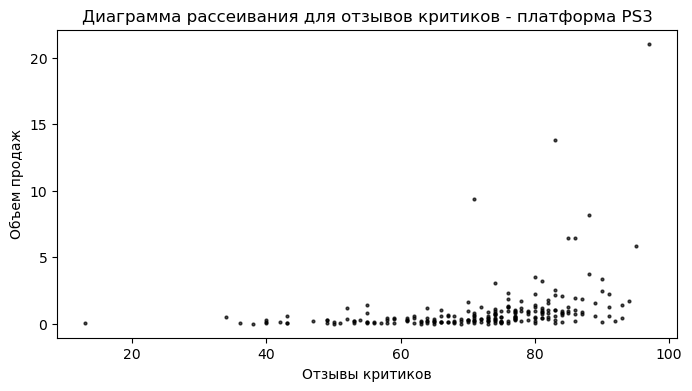

In [51]:
# построим диаграмму длая платформы PS3
corr_ps3.plot(kind='scatter', y='total_sales' , x='critic_score', alpha=0.7, subplots=True, figsize=(8,4), c = 'black', s = 4)
plt.xlabel('Отзывы критиков')
plt.ylabel('Объем продаж')
plt.title('Диаграмма рассеивания для отзывов критиков - платформа PS3');

In [52]:
# рассмотрим корреляцию оценок пользователей для платформы X360
corr_x360 = period.query('platform =="X360" and user_score < 11')
print('Корреляция оценки пользователей и продаж для платформы X360:', corr_x360['user_score'].corr(corr_x360['total_sales']))

Корреляция оценки пользователей и продаж для платформы X360: 0.006163978646213359


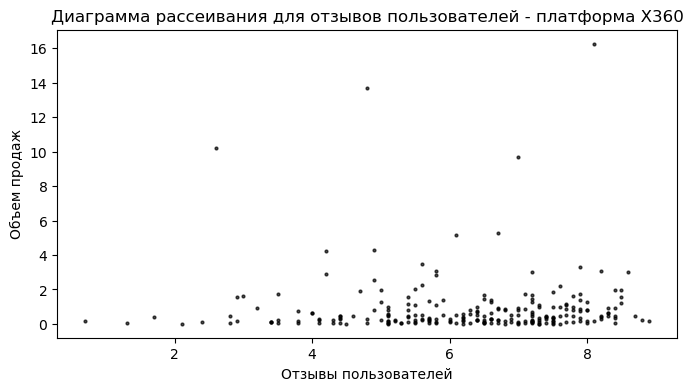

In [53]:
# построим диаграмму для платформы X360
corr_x360.plot(kind='scatter', y='total_sales' , x='user_score', alpha=0.7, subplots=True, figsize=(8,4), c = 'black', s = 4)
plt.xlabel('Отзывы пользователей')
plt.ylabel('Объем продаж')
plt.title('Диаграмма рассеивания для отзывов пользователей - платформа X360');

In [54]:
# рассмотрим корреляцию оценок критиков для платформы X360
corr_x360 = period.query('platform =="X360" and critic_score < 101')
print('Корреляция оценки критиков и продаж для платформы X360:', corr_x360['critic_score'].corr(corr_x360['total_sales']))

Корреляция оценки критиков и продаж для платформы X360: 0.36057348885073387


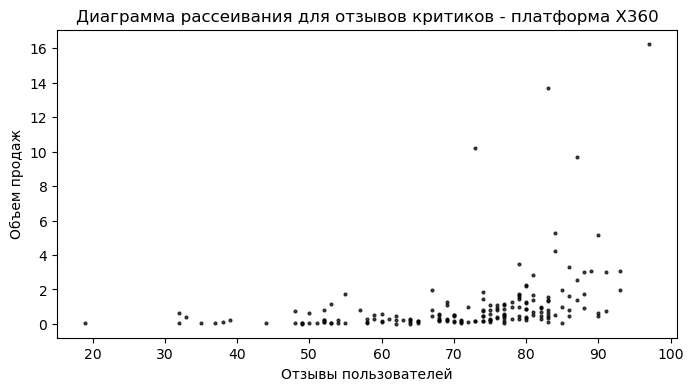

In [55]:
# построим диаграмму для платформы X360
corr_x360.plot(kind='scatter', y='total_sales' , x='critic_score', alpha=0.7, subplots=True, figsize=(8,4), c = 'black', s = 4)
plt.xlabel('Отзывы пользователей')
plt.ylabel('Объем продаж')
plt.title('Диаграмма рассеивания для отзывов критиков - платформа X360');

In [56]:
# рассмотрим корреляцию оценок пользователей для платформы 3DS
corr_3ds = period.query('platform =="3DS" and user_score < 11')
print('Корреляция оценки пользователей и продаж для платформы 3DS:', corr_3ds['user_score'].corr(corr_3ds['total_sales']))

Корреляция оценки пользователей и продаж для платформы 3DS: 0.19758263411038593


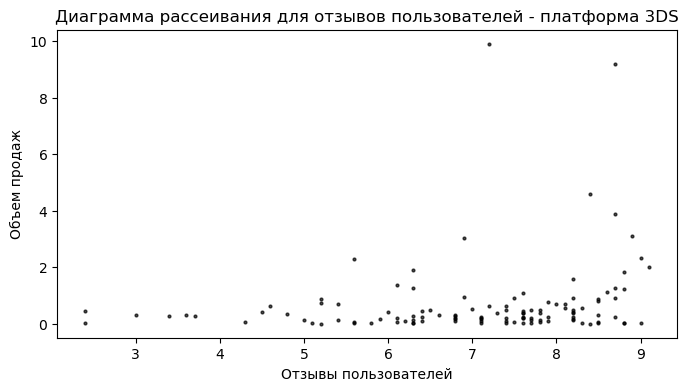

In [57]:
# построим диаграмму для платформы 3DS
corr_3ds.plot(kind='scatter', y='total_sales' , x='user_score', alpha=0.7, subplots=True, figsize=(8,4), c = 'black', s = 4)
plt.xlabel('Отзывы пользователей')
plt.ylabel('Объем продаж')
plt.title('Диаграмма рассеивания для отзывов пользователей - платформа 3DS');

In [58]:
# рассмотрим корреляцию оценок критиков для платформы 3DS
corr_3ds = period.query('platform =="3DS" and critic_score < 101')
print('Корреляция оценки критиков и продаж для платформы 3DS:', corr_3ds['critic_score'].corr(corr_3ds['total_sales']))

Корреляция оценки критиков и продаж для платформы 3DS: 0.3208028695360785


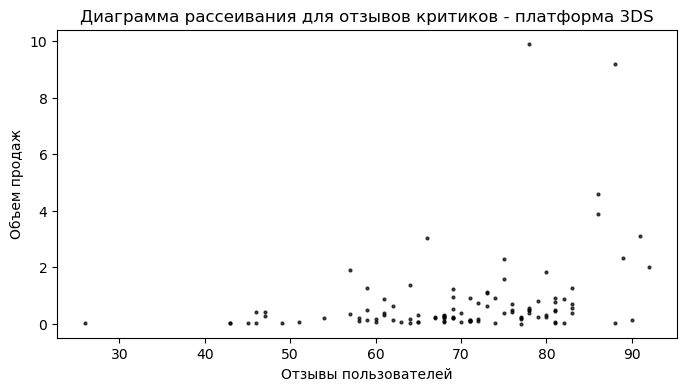

In [59]:
# построим диаграмму дла платформы 3DS
corr_3ds.plot(kind='scatter', y='total_sales' , x='critic_score', alpha=0.7, subplots=True, figsize=(8,4), c = 'black', s = 4)
plt.xlabel('Отзывы пользователей')
plt.ylabel('Объем продаж')
plt.title('Диаграмма рассеивания для отзывов критиков - платформа 3DS');

In [60]:
# рассмотрим корреляцию оценок пользователей для платформы XOne
corr_xone = period.query('platform =="XOne" and user_score < 11')
print('Корреляция оценки пользователей и продаж для платформы XOne:', corr_xone['user_score'].corr(corr_xone['total_sales']))

Корреляция оценки пользователей и продаж для платформы XOne: -0.06892505328279418


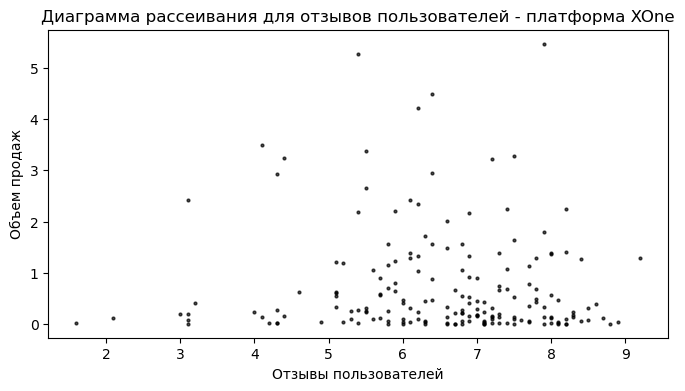

In [61]:
# построим диаграмму для платформы XOne
corr_xone.plot(kind='scatter', y='total_sales' , x='user_score', alpha=0.7, subplots=True, figsize=(8,4), c = 'black', s = 4)
plt.xlabel('Отзывы пользователей')
plt.ylabel('Объем продаж')
plt.title('Диаграмма рассеивания для отзывов пользователей - платформа XOne');

In [62]:
# рассмотрим корреляцию оценок критиков для платформы XOne
corr_xone = period.query('platform =="XOne" and critic_score < 101')
print('Корреляция оценки критиков и продаж для платформы XOne:', corr_xone['critic_score'].corr(corr_xone['total_sales']))

Корреляция оценки критиков и продаж для платформы XOne: 0.41699832800840153


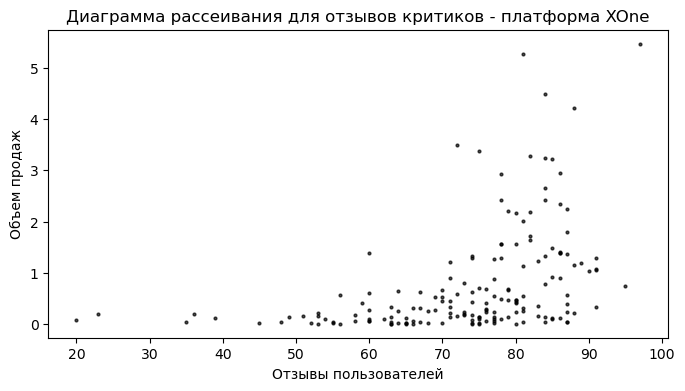

In [63]:
# построим диаграмму для платформы XOne
corr_xone.plot(kind='scatter', y='total_sales' , x='critic_score', alpha=0.7, subplots=True, figsize=(8,4), c = 'black', s = 4)
plt.xlabel('Отзывы пользователей')
plt.ylabel('Объем продаж')
plt.title('Диаграмма рассеивания для отзывов критиков - платформа XOne');

**Вывод** Рассмотрели общую корреляцию оценок пользователей и продажи, если  рассматривать вцелом все платформы, то можем отметить практически отсутствующую зависимость на продажи отзывов пользователей. Оценки критиков слабо влияют на продажи, покупатели в целом мало ориентируются на них. Распределение оценок пользователй в основном в диапазоне от 5 до 8,5 баллов, Распределение оценок критиков в диапазоне от 60 до 85 баллов. Эти оценки примерно сопоставимы с выборкой для платформы PS4. Можем сказать, что ситуация по продажам в зависимости от оценок критиков/польцователей практически сопоставима для всех платформ. 

### Посмотрим на общее распределение игр по жанрам 

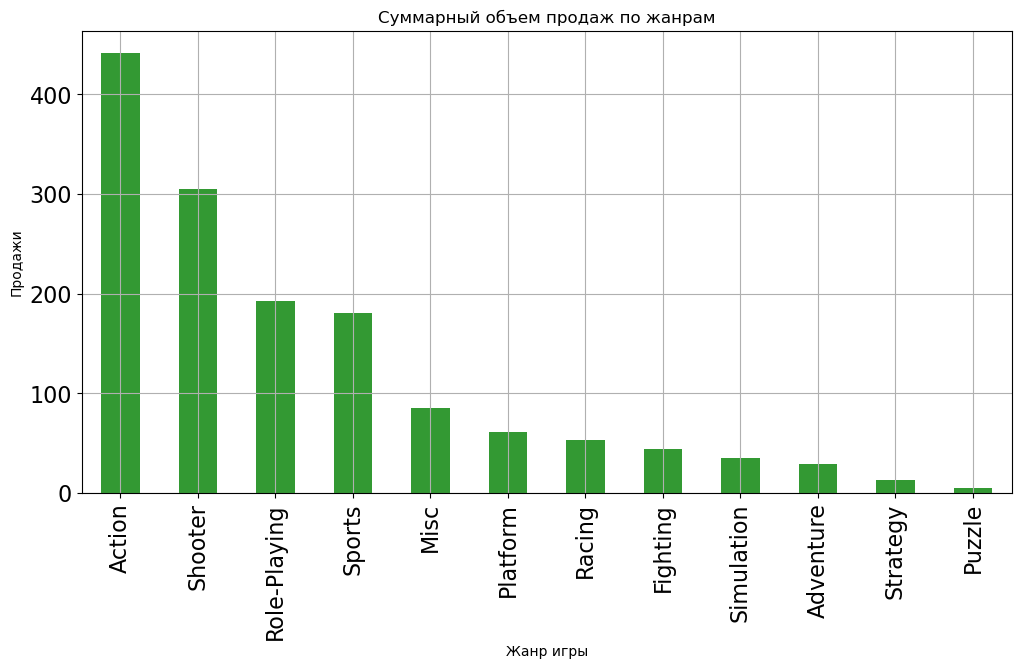

In [64]:
# создадим сводную таблицу по жанрам и продажам
(
period.pivot_table(index = 'genre', values = 'total_sales', aggfunc = 'sum').sort_values(by = 'total_sales', ascending=False)\
.plot(y = 'total_sales', kind='bar', figsize=(12, 6), title='Суммарный объем продаж по жанрам', grid=True, color='g', alpha=0.8, fontsize=16, legend=False)\
    .set(xlabel='Жанр игры', ylabel='Продажи')
)
plt.show()

*Комментарий*

Топовые жанры: Action, Sports, Role-Playing, Shooter. 

Топ-низа жанров: Puzzle, Strategy, Simulation.

In [65]:
# создам сводную таблицу по жанрам, чтоб посмотреть медиану продаж
period_genre = period.pivot_table(index = 'genre', values= 'total_sales', aggfunc = 'median')\
.sort_values(by = 'total_sales', ascending=False)
period_genre

,total_sales
genre,
Shooter,0.440
Sports,0.240
Platform,0.210
Role-Playing,0.140
Racing,0.140
Fighting,0.130
Action,0.120
Misc,0.120
Simulation,0.120


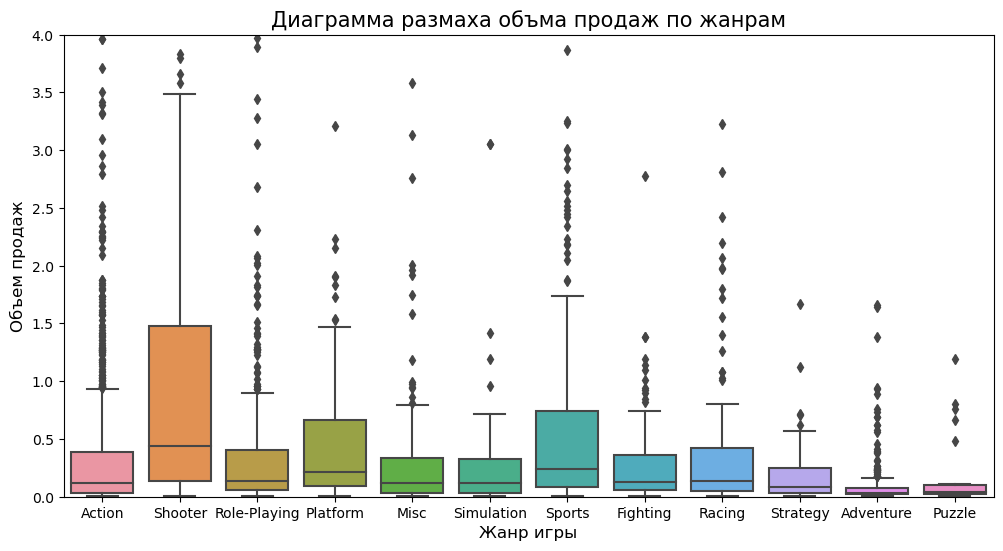

In [66]:
# нарисуем диаграмму продаж по жанрам, чтоб посмотреть на жанры со стабильными продажами.
plt.figure(figsize=(12,6))
sns.boxplot(data=period, x='genre', y='total_sales')
plt.ylim([0, 4])
plt.title('Диаграмма размаха объма продаж по жанрам', fontsize=15)
plt.xlabel('Жанр игры', fontsize=12)
plt.ylabel('Объем продаж',fontsize=12);

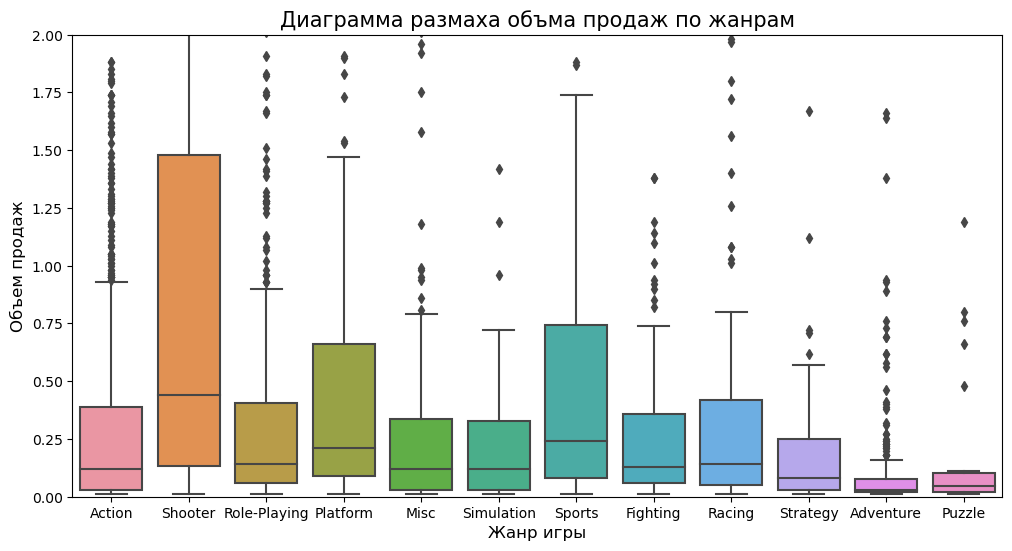

In [67]:
# масштабируем диаграмму продаж по жанрам
plt.figure(figsize=(12,6))
sns.boxplot(data=period, x='genre', y='total_sales')
plt.ylim([0, 2])
plt.title('Диаграмма размаха объма продаж по жанрам', fontsize=15)
plt.xlabel('Жанр игры', fontsize=12)
plt.ylabel('Объем продаж',fontsize=12);

*Комментарий*

Жанры со стабильными прожадами отличаются, от выведеного выше графика. Стабильно продаются: Shooter, Sports, Platform, Role-Playing, Racing.

**Итоги по исследовательскому анализу данных.**

Наибольший рост игровых приставок начался в 2000-ых годах, в среднем платформы живут около 7 лет.

Лидеры по продажам: PS4, PS3, X360, 3DS, XOne.

У всех платформ наблюдается слабая зависимость оценок пользователей на продажи. Оценки критиков слабо влияют на продажи, покупатели в целом мало ориентируются на них.


Топ жанров: Action, Sports, Role-Playing, Shooter.

Жанры со стабильными прожадами: Shooter, Sports, Platform, Role-Playing, Racing


## Составим портрет пользователя каждого региона ##

Определим для пользователя каждого региона (NA, EU, JP):

- Самые популярные платформы (топ-5). 
- Самые популярные жанры (топ-5). 
- Влияет ли рейтинг ESRB на продажи в отдельном регионе?


### Составим портрет пользователя Северной Америки

In [68]:
# создадим таблицу для платформ Северной Америки от 2012 года и продажами больше нуля
game_na = df_game.query('year_of_release >=2012 and na_sales > 0')

In [69]:
# платформы в Северной Америке
game_na_p = game_na.groupby('platform')['na_sales'].sum().sort_values(ascending=False)

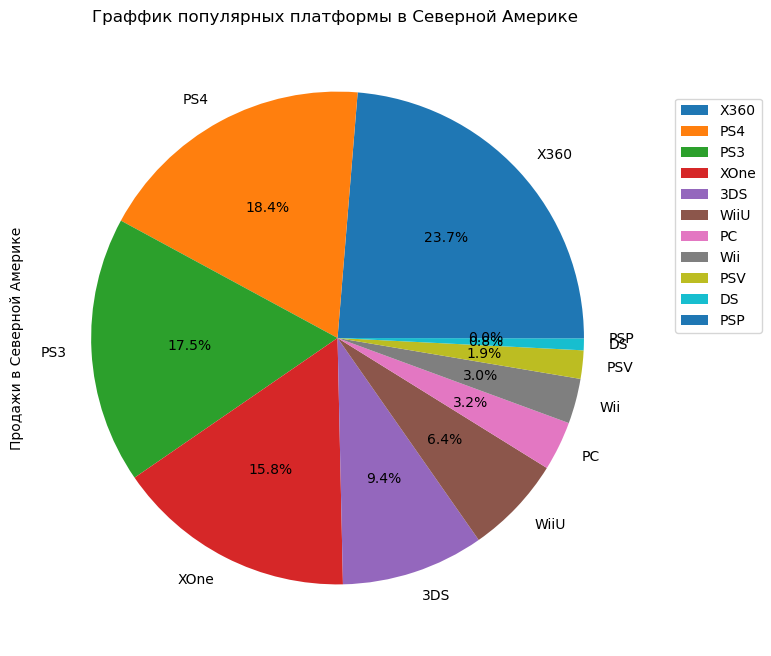

In [70]:
# нарисуем круговую диаграмму популярности платформ
game_na_p.plot(y="platform", kind="pie", figsize=(8, 8), autopct='%1.1f%%')
plt.legend(bbox_to_anchor=(0.6, 0, 0.6, 0.9)) 
plt.title('Граффик популярных платформы в Северной Америке ') 
plt.ylabel('Продажи в Северной Америке')
plt.show()

*Комментарий*

Топ-5 платформ Северной Америки

- X360: 23.7% от общего объёма 
- PS4: 18.4% от общего объёма 
- PS3: 17.5% от общего объёма 
- XOne: 15.8% от общего объёма 
- 3DS: 9.4% от общего объёма 

In [71]:
# популярные жанры в Северной Америке
game_na_g = game_na.groupby('genre')['na_sales'].sum().sort_values(ascending=False)

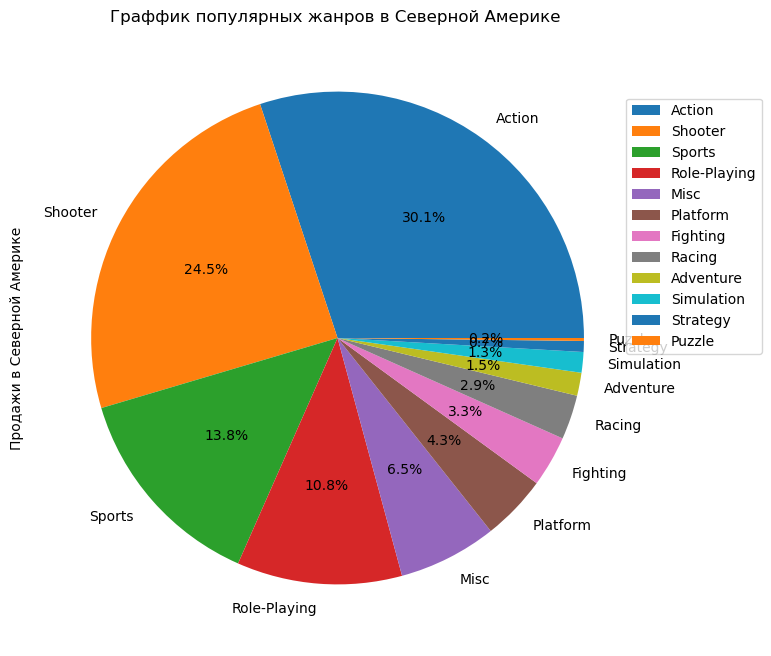

In [72]:
# нарисуем круговую диаграмму популярности жанров
game_na_g.plot(y="genre", kind="pie", figsize=(8, 8), autopct='%1.1f%%')
plt.legend(bbox_to_anchor=(0.6, 0, 0.6, 0.9)) 
plt.title('Граффик популярных жанров в Северной Америке ') 
plt.ylabel('Продажи в Северной Америке')
plt.show()

*Комментарий*

Топ-5 популярных жанров в Северной Америке

- Action: 30.1% от общего объёма 
- Shooter: 24.5% от общего объёма 
- Sports: 13.8% от общего объёма
- Role-Playing: 10.8% от общего объёма 
- Misc: 6.5% от общего объёма 

In [73]:
# предпочитаемые рейтинги в Северной Америке
game_na_r = game_na.groupby('rating')['na_sales'].sum().sort_values(ascending=False)

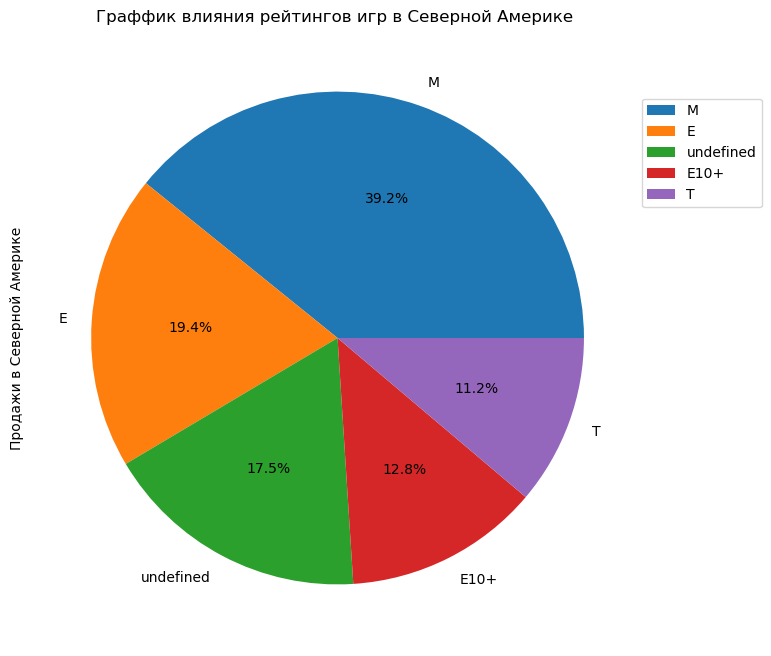

In [74]:
# нарисуем круговую диаграмму рейтингов
game_na_r.plot(y="rating", kind="pie", figsize=(8, 8), autopct='%1.1f%%')
plt.legend(bbox_to_anchor=(0.6, 0, 0.6, 0.9)) 
plt.title('Граффик влияния рейтингов игр в Северной Америке ') 
plt.ylabel('Продажи в Северной Америке')
plt.show()

*Комментарий*

Оценив полученные данные в граффике, могу сказать, что рейтинг ESRB влияет на объем продаж игр в Северной Америке. Объем продаж наибольший у игр с рейтингом М (39.2%), которые подходят для лиц старше 17 лет. Меньше продаж у игр с рейтингами Т (11.2%) и Е10+ (12.8%), эти игры подходят для лиц старше 10 и 13 лет.    

### Составим портрет пользователя Европы

In [75]:
# создадим таблицу для платформ Европпы от 2012 года и продажами больше нуля
game_eu = df_game.query('year_of_release >=2012 and eu_sales > 0')

In [76]:
# платформы в Европе
game_eu_p = game_eu.groupby('platform')['eu_sales'].sum().sort_values(ascending=False)

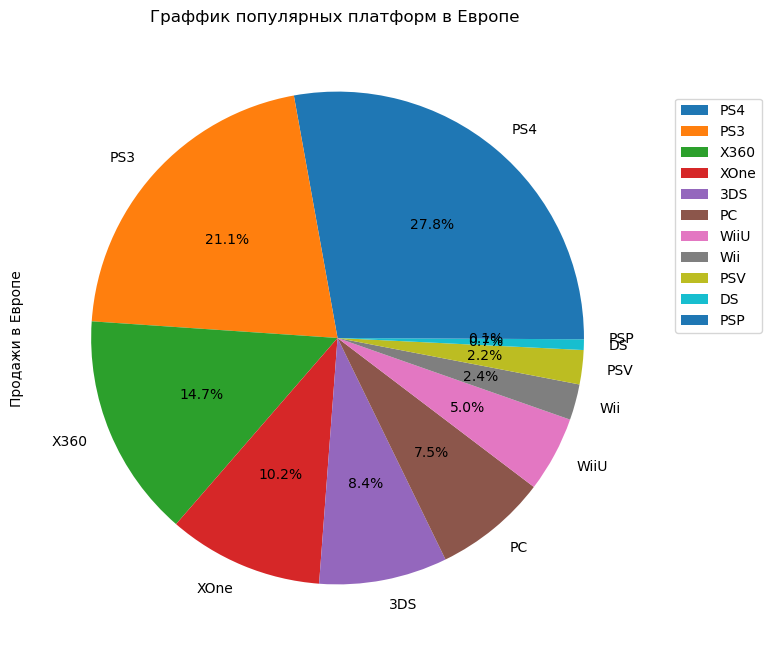

In [77]:
# нарисуем круговую диаграмму популярности платформ
game_eu_p.plot(y="platform", kind="pie", figsize=(8, 8), autopct='%1.1f%%')
plt.legend(bbox_to_anchor=(0.6, 0, 0.6, 0.9)) 
plt.title('Граффик популярных платформ в Европе ') 
plt.ylabel('Продажи в Европе')
plt.show()

*Комментарий*

Топ-5 популярных платформа в Европе:

- PS4: 27.8% от общего объёма
- PS3: 21.1% от общего объёма
- X360: 14.7% от общего объёма
- XOne: 10.2% от общего объёма
- 3DS: 8.4% от общего объёма

In [78]:
# популярные жанры в Европе
game_eu_g = game_eu.groupby('genre')['eu_sales'].sum().sort_values(ascending=False)

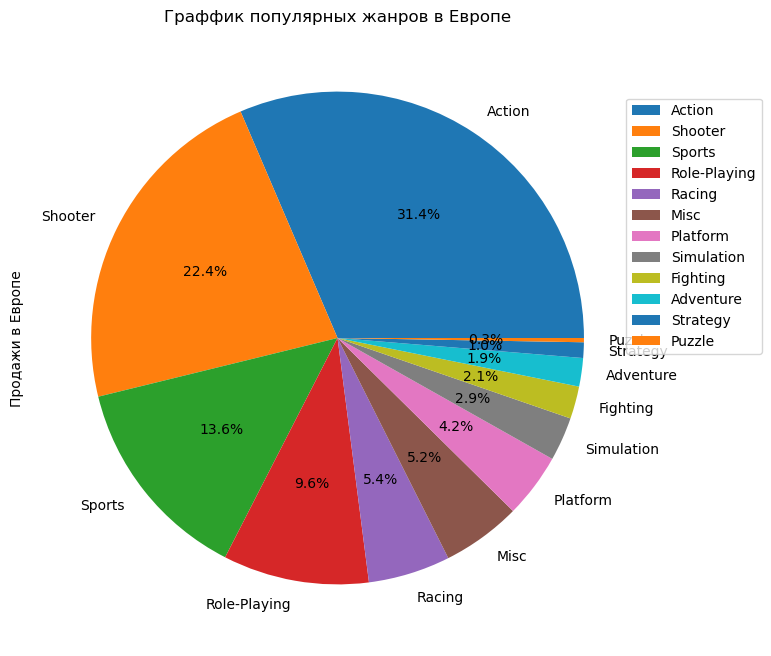

In [79]:
# нарисуем круговую диаграмму популярности жанров
game_eu_g.plot(y="genre", kind="pie", figsize=(8, 8), autopct='%1.1f%%')
plt.legend(bbox_to_anchor=(0.6, 0, 0.6, 0.9)) 
plt.title('Граффик популярных жанров в Европе') 
plt.ylabel('Продажи в Европе')
plt.show()

*Комментарий*

Топ-5 популярных жанров в Европе:

- Action: 31.7% от общего объёма рынка
- Shooter: 23.0% от общего объёма рынка
- Sports: 13.3% от общего объёма рынка
- Role-Playing: 9.7% от общего объёма рынка
- Racing: 5.3% от общего объёма рынка

In [80]:
# предпочитаемые рейтинги в Европе
game_eu_r = game_eu.groupby('rating')['eu_sales'].sum().sort_values(ascending=False)

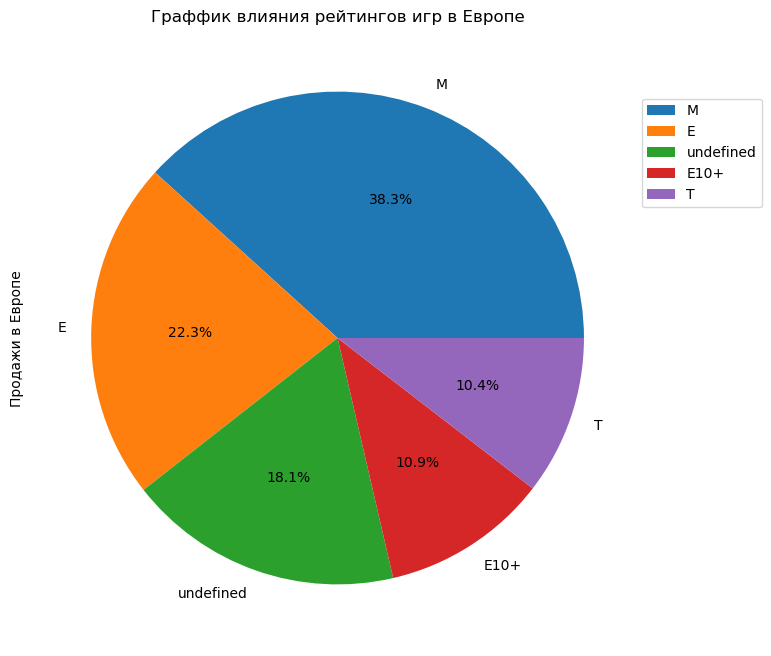

In [81]:
# нарисуем круговую диаграмму рейтингов
game_eu_r.plot(y="rating", kind="pie", figsize=(8, 8), autopct='%1.1f%%')
plt.legend(bbox_to_anchor=(0.6, 0, 0.6, 0.9)) 
plt.title('Граффик влияния рейтингов игр в Европе') 
plt.ylabel('Продажи в Европе')
plt.show()

*Комментарий*

Рейтинг ESRB влияет на объем продаж игр в Европе. Как и в Северной Америке, в Европе популярен рейтинг игр - М (39.3%), которые подходят для лиц старше 17 лет. Меньше продаж у игр с рейтингами Т (10.3%) и Е10+ (10.9%), эти игры подходят для лиц старше 10 и 13 лет.   

### Составим портрет пользователя в Японии

In [82]:
# создадим таблицу для платформ Японии от 2012 года и продажами больше нуля
game_jp = df_game.query('year_of_release >=2012 and jp_sales > 0')

In [83]:
# платформы в Японии
game_jp_p = game_jp.groupby('platform')['jp_sales'].sum().sort_values(ascending=False)

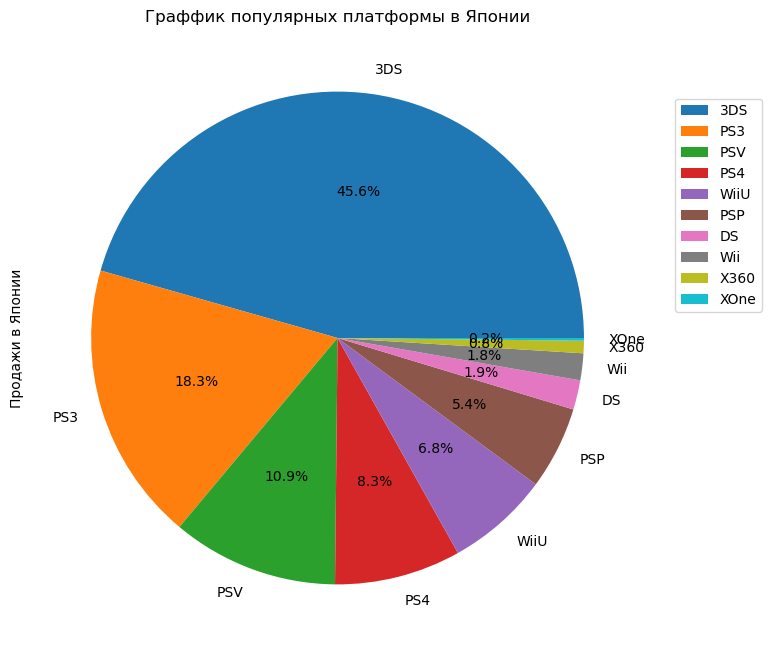

In [84]:
# нарисуем круговую диаграмму популярности платформ
game_jp_p.plot(y="platform", kind="pie", figsize=(8, 8), autopct='%1.1f%%')
plt.legend(bbox_to_anchor=(0.6, 0, 0.6, 0.9)) 
plt.title('Граффик популярных платформы в Японии') 
plt.ylabel('Продажи в Японии')
plt.show()

*Комментарий*

Топ-5 популярных платформ в Японии:

- 3DS: 45.6% от общего объёма
- PS3: 18.3% от общего объёма
- PSV: 10.9% от общего объёма
- PS4: 8.3% от общего объёма
- WiiU: 6.8% от общего объёма

In [85]:
# популярные жанры в Японии
game_jp_g = game_jp.groupby('genre')['jp_sales'].sum().sort_values(ascending=False)

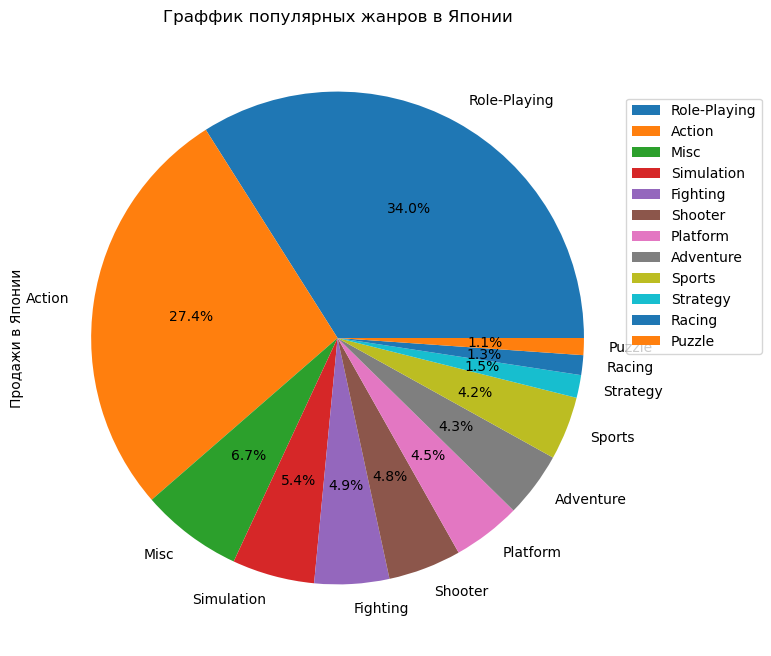

In [86]:
# нарисуем круговую диаграмму популярности жанров
game_jp_g.plot(y="genre", kind="pie", figsize=(8, 8), autopct='%1.1f%%')
plt.legend(bbox_to_anchor=(0.6, 0, 0.6, 0.9)) 
plt.title('Граффик популярных жанров в Японии') 
plt.ylabel('Продажи в Японии')
plt.show()

*Комментарий*

Топ-5 популярных жанров в Японии:

- Role-Playing: 34.0% от общего объёма
- Action: 27.4% от общего объёма
- Misc: 6.7% от общего объёма
- Simulation: 5.4% от общего объёма
- Fighting: 4.9% от общего объёма

In [87]:
# предпочитаемые рейтинги в Японии
game_jp_r = game_jp.groupby('rating')['jp_sales'].sum().sort_values(ascending=False)

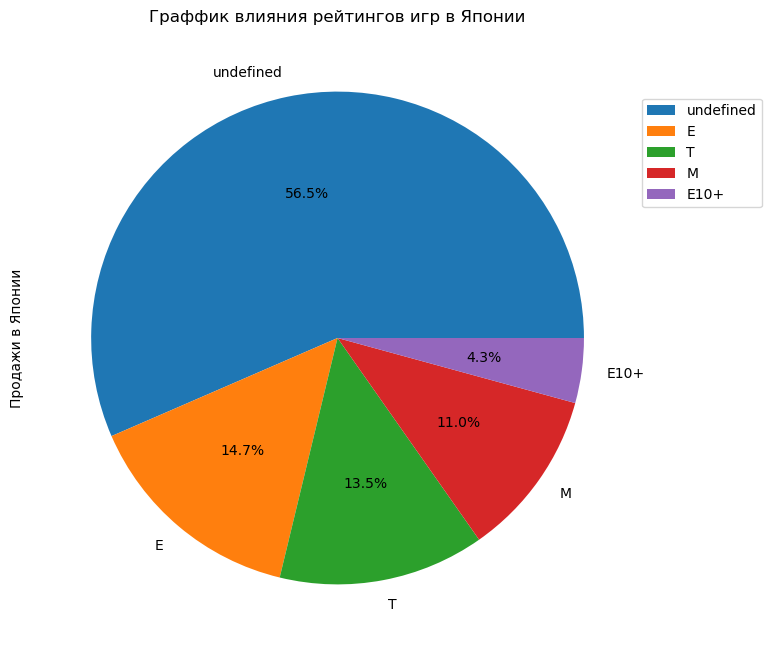

In [88]:
# нарисуем круговую диаграмму рейтингов
game_jp_r.plot(y="rating", kind="pie", figsize=(8, 8), autopct='%1.1f%%')
plt.legend(bbox_to_anchor=(0.6, 0, 0.6, 0.9)) 
plt.title('Граффик влияния рейтингов игр в Японии') 
plt.ylabel('Продажи в Японии')
plt.show()

*Комментарий*

По граффику видим, что наибольший процент составляет рейтинг - undefined, которым мы заменили пропуски. Рейтинг ESRB предназначен для маркировки игр для США и Канады, поэтому для других регионов он не заполняется. В Японии есть свой рейтинг, свой рейтинг есть в ЕС и т.д., но по ним в датасете нет данных.  

Популярным является рейтинг Е (24.4%), подходит для всех возрастных категорий. Наименее популярный рейтинг Е10+.  



### Составим портрет пользователя в других странах

In [89]:
# создадим таблицу для платформ 
game_other = df_game.query('year_of_release >=2012 and other_sales > 0')

In [90]:
# платформы в других странах
game_other_p = game_other.groupby('platform')['other_sales'].sum().sort_values(ascending=False)

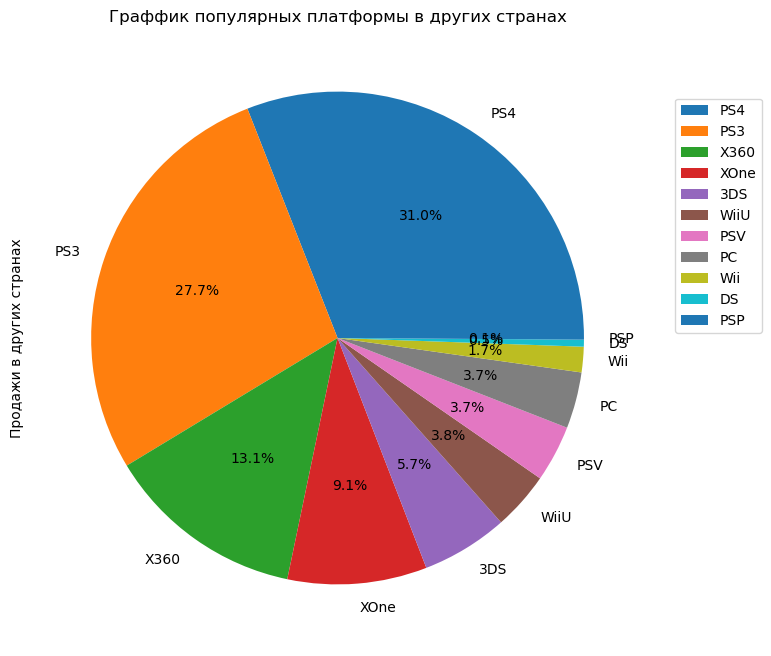

In [91]:
# нарисуем круговую диаграмму популярности платформ
game_other_p.plot(y="platform", kind="pie", figsize=(8, 8), autopct='%1.1f%%')
plt.legend(bbox_to_anchor=(0.6, 0, 0.6, 0.9)) 
plt.title('Граффик популярных платформы в других странах') 
plt.ylabel('Продажи в других странах')
plt.show()

*Комментарий*

Топ-5 популярных платформ в других странах:

- PS4: 31% от общего объёма
- PS3: 27.7% от общего объёма
- X360: 13.1% от общего объёма
- XOne: 9.1% от общего объёма
- 3DS: 5.7% от общего объёма

In [92]:
# популярные жанры 
game_other_g = game_other.groupby('genre')['other_sales'].sum().sort_values(ascending=False)

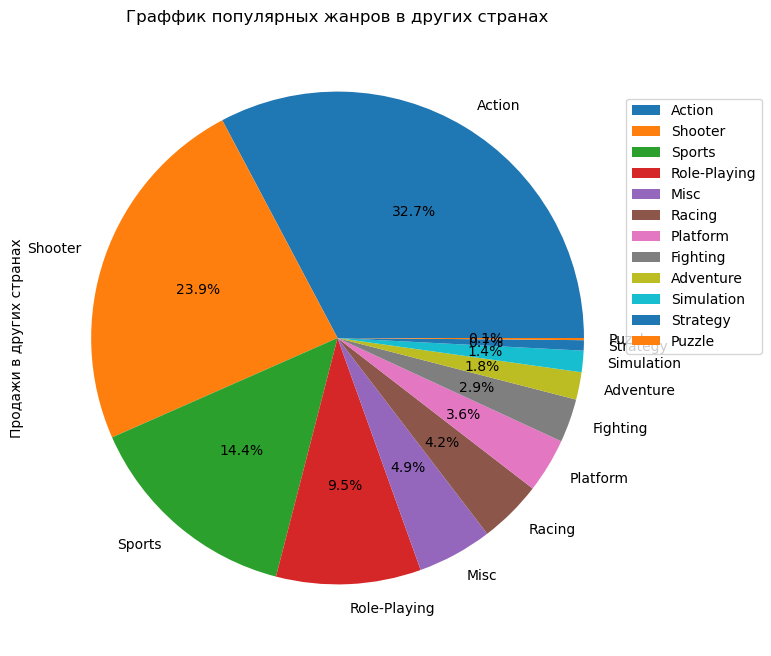

In [93]:
# нарисуем круговую диаграмму популярности жанров
game_other_g.plot(y="genre", kind="pie", figsize=(8, 8), autopct='%1.1f%%')
plt.legend(bbox_to_anchor=(0.6, 0, 0.6, 0.9)) 
plt.title('Граффик популярных жанров в других странах') 
plt.ylabel('Продажи в других странах')
plt.show()

*Комментарий*

Топ-5 популярных жанров в других странах:

- Action: 32.8% от общего объёма рынка
- Shooter: 24.1% от общего объёма рынка
- Sports: 14.2% от общего объёма рынка
- Role-Playing: 9.5% от общего объёма рынка
- Misc: 4.9% от общего объёма рынка

In [94]:
# предпочитаемые рейтинги 
game_other_r = game_other.groupby('rating')['other_sales'].sum().sort_values(ascending=False)

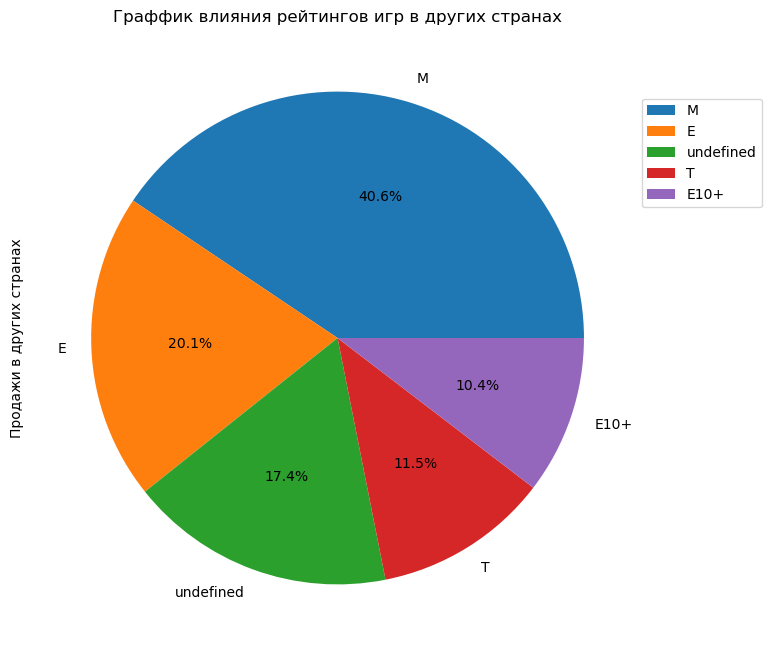

In [95]:
# нарисуем круговую диаграмму рейтингов
game_other_r.plot(y="rating", kind="pie", figsize=(8, 8), autopct='%1.1f%%')
plt.legend(bbox_to_anchor=(0.6, 0, 0.6, 0.9)) 
plt.title('Граффик влияния рейтингов игр в других странах') 
plt.ylabel('Продажи в других странах')
plt.show()

*Комментарий*

На продажи в другий странах рейтинг ESRB имеет влияние. Продаваемые игры с рейтингом М (41.0%), меньше продаж у рейтинга Е10+.

**Вывод**

Мы проанализировали пользовательский портрет в каждом регионе: NA, EU, JP и других регионах. Можем выделить схожие пользовательские предпочтения: 

- Популярный рейтинг игр - М
- Популярные платформы - PS4, PS3, X360
- Популярный жанр - Action


Так же может отдельно выделить рынок игровых платформ в Японии, пользовательские предпочтения отличаются от остальных регионов.

## Проверим гипотезы ##

### Проверяем условие: "Средние пользовательские рейтинги платформ Xbox One и PC одинаковые"

H0 Средние пользовательские рейтинги платформ Xbox One и PC равны.

H1 Средние пользовательские рейтинги платформ Xbox One и PC не равны. 

Применим t-критерий Уэлча. Используем формулу st.ttest_ind() для двух выборок разный генеральных совокупностей и укажем equal_var=False.



In [96]:
# получим выборку для платформы Xbox One
grade_xone = df_game.query('platform =="XOne" and user_score > 0 and user_score < 11 and year_of_release >=2012')['user_score']

In [97]:
# средняя оценка пользователей для платформы Xbox One
grade_xone.mean()

6.521428571428572

In [98]:
# получим выборку для платформы PC
grade_pc = df_game.query('platform =="PC" and user_score > 0 and user_score < 11 and year_of_release >=2012')['user_score']

In [99]:
# средняя оценка пользователей  для платформы PC
grade_pc.mean()

6.4286407766990274

In [100]:
alpha = 0.01

results = st.ttest_ind(grade_xone, grade_pc, equal_var=False)

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не отвергаем нулевую гипотезу')

p-значение: 0.5489537965134912
Не отвергаем нулевую гипотезу


*Комментарий*

Не получилось отвергнуть нулевую гипотезу, так как р-значение 0,54. Значит мы можем предполагать, что средний пользовательский рейтинг платформ Xbox One и PC равны. Даже при значении alpha = 0.05. 

### Проверяем условие: "Средние пользовательские рейтинги жанров Action (англ. «действие», экшен-игры) и Sports (англ. «спортивные соревнования») разные"

Н0 Средние пользовательские рейтинги жанров Action и Sports равные.

Н1 Средние пользовательские рейтинги жанров Action и Sports не равны.

Так же применим t-критерий Уэлча. Используем формулу st.ttest_ind() для двух выборок разный генеральных совокупностей и укажем equal_var=False.

In [101]:
# получим выборку для жанра Action
grade_action = df_game.query('genre =="Action" and user_score > 0 and user_score < 11 and year_of_release >=2012')['user_score']

In [102]:
# средняя оценка пользователей для жанра Action
grade_action.mean()

6.825047801147227

In [103]:
# получим выборку для жанра Sports
grade_sports = df_game.query('genre =="Sports" and user_score > 0 and user_score < 11 and year_of_release >=2012')['user_score']

In [104]:
# средняя оценка пользователей для жанра Sports
grade_sports.mean()

5.455670103092784

In [105]:
alpha = 0.01

results = st.ttest_ind(grade_action, grade_sports, equal_var=False)

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не отвергаем нулевую гипотезу')

p-значение: 5.989458066467418e-20
Отвергаем нулевую гипотезу


*Комментарий*

Отвергаем нулевую гипотезу о равенстве средних значений пользовательских рейтингов жанров Action и Sports в пользу альтернативной гипотезы, р-значение - 5.98. 

## Вывод ##

Была проведена подготовка данных: приведены названия столбцов к единому регистру; нашла пропуски и обработала их; заменила типы данных в столбцах; создала столбец с суммарными продажами по всем регионам. 

Далее при анализе:

+ Узнала, что абревиатура 'tbd' означает термин TBD - To Be Determined, то есть "Будет определено". Но в нашем случае, значение может быть интерпритированно, как To Be Discussed - подлежит обсуждению. Вероятно появление этого значения в наших данных связано с затруднением оценки, либо их было не достаточно для определения. Значение 'tbd' заменим на ноль.
+ Во время анализа определили, что активный рост продаж игровых платформ был в 2000-ых годах. В среднем платформы "живут" около 7-8 лет. 
+ За "Актуальный период" для построения прогноза на 2017 год, взяла период с 2012 по 2016 г.
+ Платформы лидирующие по продажам: PS3, X360, 3DS, XOne. 
+ Рассмотрела влияние продаж на примере платформы PS4.
+ У всех платформ наблюдается слабая зависимость оценок пользователей на продажи. И средняя зависимость оценок критиков на продажи. Покупатели склонны больше доверять мнению критиков.
+ Топ жанров: Action, Sports, Role-Playing, Shooter.
+ Топ жанров со стабильными продажами: Shooter, Sports, Platform, Role-Playing, Racing.
+ Составила портрет пользователей каждого региона. Выявила общие черты: популярный рейтинг игр - М; популярные платформы - PS4, PS3, X360; популярный жанр - Action, Shooter.
+ В Японии на первом месте по рейтингу игр выделяется данные, которые были названы  "undefined". Это рейтинги игр с классификацие стран не относящихся к ассоциации ESRB. Самая популярная платформа - 3DS; популярный жанр - Role-Playing.

Проверила две гипотезы: 
+ "Средние пользовательские рейтинги платформ Xbox One и PC одинаковые"
+ "Средние пользовательские рейтинги жанров Action (англ. «действие», экшен-игры) и Sports (англ. «спортивные соревнования») разные"

В итоге, могу сказать, что средний пользовательский рейтинг платформ Xbox One и PC равный и средние пользовательские выборки жанров Action и Sports не равны.

---
Для рекламной компании в странах Северной Америки и Европы, стоит обратить внимание на платформы PS4 и X360, предпочитаемые жанры - Shooter, Sports и Action(не смотря на нестабильность продаж, можно рассмотреть популярные игры в этом жанре). Для региона Северной Америки рейтинг возьмем М, для Европы и других стран - М и рейтинги с их классификаций игр, если они соответствуют М ESRB. Если нас интересует Японский рынок, то упор делаем на платформу 3DS и PS3, жанры - Role-Playing и Action. Японцы предпочитают игры не относящиеся к  рейтингам ассоциации ESRB и Е классификации ESRB. Не стоит обращать внимание на отзывы пользователей и критиков.
